In [17]:
# initial imports
import os
import plotly.express as px
from dotenv import load_dotenv
import panel as pn
# Initialize the Panel Extensions (for Plotly)
pn.extension('plotly')
import hvplot.pandas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import plotly.express as px
from dotenv import get_key
%matplotlib inline
from datetime import datetime

In [18]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("mapbox")
px.set_mapbox_access_token(mapbox_token)

In [19]:
file_path = Path("Resources/amd_stock_data.csv")
amd = pd.read_csv(file_path, infer_datetime_format=True, parse_dates=True)
amd = amd.rename(columns={
    "date": "Date"
})
amd.Date = pd.to_datetime(amd.Date)
amd = amd.set_index("Date")
amd.head()

,close,volume,open,high,low
Date,,,,,
2009-04-29,3.51,11537950,3.40,3.56,3.38
2009-04-30,3.61,18193730,3.55,3.73,3.53
2009-05-01,3.82,16233940,3.55,3.90,3.55
2009-05-04,4.26,21236940,3.90,4.30,3.83
2009-05-05,4.32,16369170,4.36,4.39,4.11


In [20]:
# Reading S&P 500 Closing Prices
sp500_history_csv = Path("Resources/sp500_history.csv")
sp500 = pd.read_csv(sp500_history_csv, infer_datetime_format=True, parse_dates=True)
# Fix Data Types
# Changing the "Close" columns to a float type and removed the $ symbol
sp500["Close"] = sp500["Close"].str.replace("$", "")
sp500["Close"] = sp500["Close"].astype("float")
# Renamed the columns from "Close" to "S&P500"
sp500 = sp500.rename(columns={
    "Close": "close"
})
sp500.Date = pd.to_datetime(sp500.Date)
sp500 = sp500.set_index("Date")
sp500.head()

,close
Date,
2019-04-23,2933.68
2019-04-22,2907.97
2019-04-18,2905.03
2019-04-17,2900.45
2019-04-16,2907.06


In [21]:
# Reading whale returns
whale_returns_csv = Path("Resources/whale_returns.csv")
whale = pd.read_csv(whale_returns_csv, index_col="Date", infer_datetime_format=True, parse_dates=True)
# Drop nulls
whale.dropna(inplace=True)
#whale.head()

In [22]:
# Reading algorithmic returns
algo_returns_csv = Path("Resources/algo_returns.csv")
algo = pd.read_csv(algo_returns_csv, index_col="Date", infer_datetime_format=True, parse_dates=True)
# Drop nulls
algo.dropna(inplace=True)
#algo.head()

<AxesSubplot:title={'center':'Rolling 20-day Exponentially Weighted Moving Average of AMD'}, xlabel='Date'>

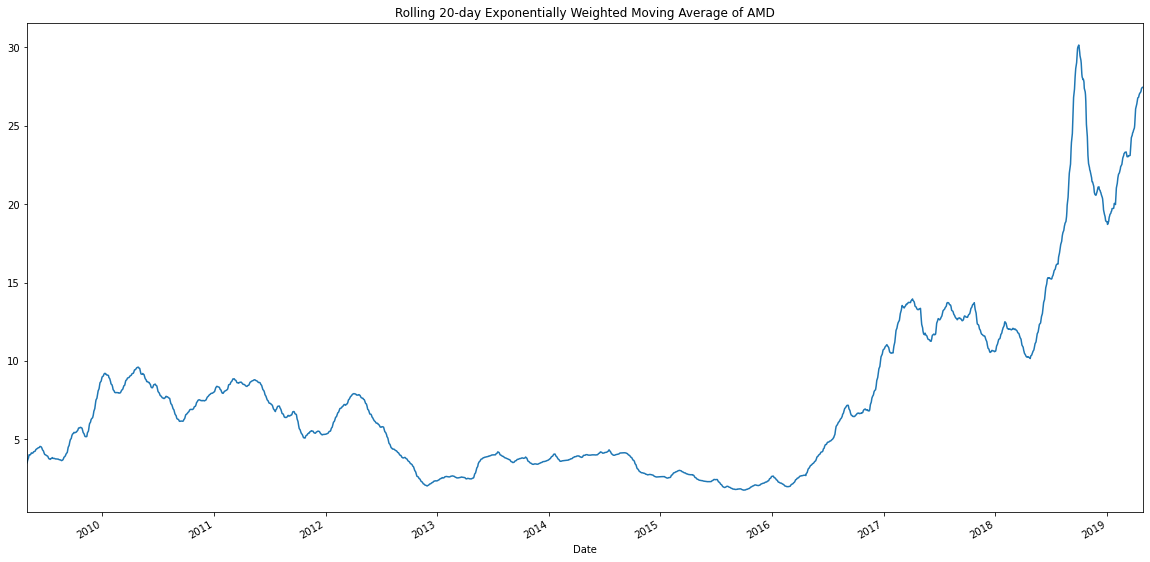

In [23]:
ewm = amd["close"].ewm(span=20).mean()
ewm.plot(figsize=(20,10), title="Rolling 20-day Exponentially Weighted Moving Average of AMD")

In [24]:
# Calculate Daily Returns
sp500_pc = sp500["close"].pct_change()
# Sort SP500 in ascending order
sp500_pc = sp500_pc.sort_index()
# Drop nulls
sp500_pc = sp500_pc.dropna()
# Renamed the columns from "Close" to "S&P500"
sp500_pc = sp500_pc.rename(columns={
    "close": "S&P500"
})



# Calculate Daily Returns
amd_pc = amd["close"].pct_change()
# Sort SP500 in ascending order
amd_pc = amd_pc.sort_index()
# Drop nulls
amd_pc = amd_pc.dropna()
# Renamed the columns from "Close" to "S&P500"
amd_pc = amd_pc.rename(columns={
    "close": "AMD"
})

#sp500_pc.head()
#amd_pc.head()

In [25]:
# Concatenate all DataFrames into a single DataFrame
joined_data_cols = pd.concat([amd_pc, sp500_pc], axis="columns", join="inner")
joined_data_cols = joined_data_cols.dropna()
cols = ['AMD', 'S&P500']
joined_data_cols.columns = cols
joined_data_cols.head()

,AMD,S&P500
Date,,
2012-10-01,-0.026706,-0.000872
2012-10-02,-0.003049,-0.003611
2012-10-03,-0.045872,-0.007123
2012-10-04,0.032051,0.000322
2012-10-05,0.000000,0.003469


-0.09082029485285249


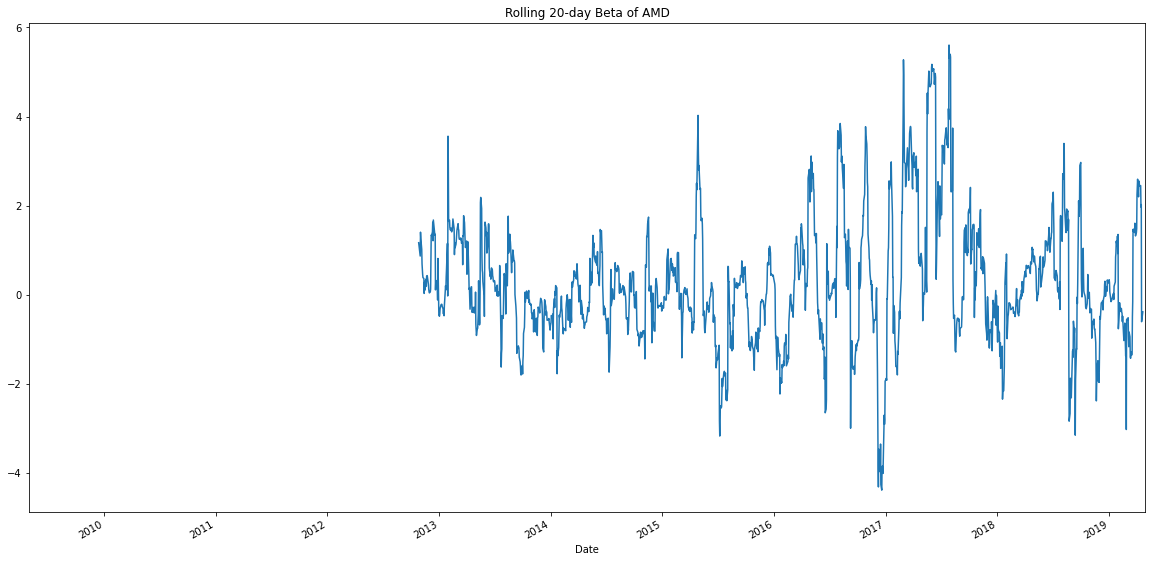

In [26]:
# Beta
covariance = amd_pc.cov(sp500_pc)
variance = sp500_pc.var()
AMD_beta = covariance / variance
# Calculate 20 day rolling covariance
AMD_cov_roll = amd_pc.rolling(window=20).cov(sp500_pc)
# Calculate 20 day rolling variance
AMD_var_roll = sp500_pc.rolling(window=20).var()
# Calculate 21 day rolling beta of AMD vs S&P
AMD_beta_roll = AMD_cov_roll / AMD_var_roll
AMD_beta_roll.plot(figsize=(20,10), title="Rolling 20-day Beta of AMD")
print(AMD_beta)

In [27]:
#sp500.corr()

In [28]:
#amd_pc.plot.box(figsize=(20,10))

In [66]:
def get_financial_plots(event):
    "function to create beta, sharpe ratio, SMA EMA plots"
    plot = ewm.plot(figsize=(20,10), title="Rolling 20-day Exponentially Weighted Moving Average of AMD")
    panel_tabs_view.active=0
    return[plot.figure]
        

In [67]:
panel_tabs_view = pn.Tabs(
     ("Welcome", check_visual),
     ("Base Data", check_visual), dynamic=True,
        height_policy = 'auto', width_policy = 'auto', align='start', sizing_mode='scale_both', tabs_location='right')

In [68]:
visualization_group = pn.widgets.CheckBoxGroup(
    name='Checkbox Group', value=['beta', 'Correlation', 'Weighted Moving Average'], 
    options=['alpha', 'beta', 'Correlation', 'Simple Moving Average', 'Weighted Moving Average'],
    inline=True)
visualization_group

CheckBoxGroup(inline=True, name='Checkbox Group', options=['alpha', 'beta', ...], value=['beta', 'Correlation', ...])

In [69]:
#visualization_group.value

In [70]:
#pn.Row(visualization_group.controls(jslink=True), visualization_group)

In [71]:
visualization_button = pn.widgets.Button(name='Visualize', button_type='primary', width=5)
visualization_button.on_click(get_financial_plots)

In [72]:
#pn.Row(visualization_button.controls(jslink=True), visualization_button)

In [73]:
check_visual = pn.Column(visualization_group, visualization_button)
check_visual

Column
    [0] CheckBoxGroup(inline=True, name='Checkbox Group', options=['alpha', 'beta', ...], value=['beta', 'Correlation', ...])
    [1] Button(button_type='primary', name='Visualize', width=5)

In [74]:
panel_tabs_view.show()

Launching server at http://localhost:59023
